# Processing Remote Geodata

- Contributors: Serge Rey (sjsrey@gmail.com)

## Introduction

Geographical data is ubiquitous on the internet. To tap into this cornocopia, it is useful to know how to connect to remote geographical data sets in a automated fashion rather than having to manually download a remote file prior to working with its data.

In this notebook, we demonstrate how to pull in a remote file, extract its contents, and construct new variables for later processing and analysis.



## Connecting to a Remote Dataset

We will use a remote dataset that is published by the [Southern California Association of Governments (SCAG)](http://www.scag.ca.gov/Pages/default.aspx). This dataset consists of 2010 Census information reported for tracts in the six-county SCAG region.

The data is made available at the following url: http://gisdata.scag.ca.gov/Lists/GISData/Attachments/25/tract_boundary_scag_2010.zip

We will store this url as a variable `url`:

In [1]:
url = 'http://gisdata.scag.ca.gov/Lists/GISData/Attachments/25/tract_boundary_scag_2010.zip'

Next, we import the libraries we shall need and configure the notebook for subsquent visualization:

In [2]:
import geopandas
import requests
import zipfile
import io
import os
%matplotlib inline


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

To connect to the server that hosts the file, we will use the `requests` module:

In [3]:
print('Requesting our url')
r = requests.get(url)

Requesting our url


Once the request is served, we can download the contents to a temporary location on our machine. Here we note that the original file is a [Zip archive](https://en.wikipedia.org/wiki/Zip_(file_format)). As such, we will use the Python library [zipfile](https://docs.python.org/3.8/library/zipfile.html) to interact with the contents we just received:

In [4]:
pth = 'tmp/' # FIX: make portable

z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(pth)

In [5]:
file_names = [ name for name in sorted(z.namelist()) for suffix in ['dbf', 'prj', 'shp', 'shx'] if name.endswith(suffix)]

In [6]:
file_names

['tract_boundary_scag_2010.dbf',
 'tract_boundary_scag_2010.prj',
 'tract_boundary_scag_2010.shp',
 'tract_boundary_scag_2010.shx']

With the file names available, we can use [geopandas](https://geopandas.org/index.html) to read the shapefile into a [GeoDataFrame](https://geopandas.org/data_structures.html#geodataframe) and inspect the contents:

In [7]:
dbf, prj, shp, shx = file_names
gdf = geopandas.read_file(os.path.join(pth, shp))

In [8]:
gdf.head()

,PARTIAL_ID,COUNTY,TRACT,CITY,TOTPOP,HISP,NHWHT,NHBLK,NHNATIVE,NHASIAN,...,NHOTHER18,NH2MORE18,AREA_,PERIMETER,X_CENTER,Y_CENTER,ACRES,Shape_area,Shape_len,geometry
0,02508058010300,025,010300,08058,2.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,2.478653e+06,15611.463767,639296.536107,3.651190e+06,612.486043,2.478653e+06,15611.464023,"MULTIPOLYGON (((640076.526 3652401.347, 640077..."
1,02508058010400,025,010400,08058,7101.0,6684.0,254.0,100.0,13.0,9.0,...,0.0,22.0,5.276661e+06,9698.994096,638184.765959,3.651029e+06,1303.886010,5.276661e+06,9698.993993,"POLYGON ((639260.064 3652389.519, 639264.504 3..."
2,02508058010500,025,010500,08058,6537.0,5027.0,1229.0,106.0,35.0,68.0,...,3.0,35.0,2.564496e+06,9333.568276,636129.568550,3.650635e+06,633.698163,2.564496e+06,9333.568204,"POLYGON ((636660.171 3651922.624, 636681.977 3..."
3,02508058010600,025,010600,08058,6995.0,4569.0,2100.0,80.0,26.0,155.0,...,6.0,32.0,5.877057e+06,12972.382048,635839.768256,3.648545e+06,1452.246583,5.877057e+06,12972.382242,"POLYGON ((637397.351 3649879.655, 637389.289 3..."
4,02508058010700,025,010700,08058,4318.0,4063.0,140.0,83.0,12.0,3.0,...,0.0,7.0,3.691516e+06,9639.000778,638201.493284,3.648988e+06,912.189807,3.691516e+06,9639.000684,"POLYGON ((636750.250 3647338.661, 636714.726 3..."


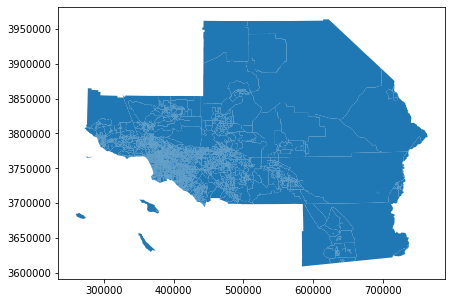

In [9]:
gdf.plot()

## Creating New Attributes

Often there is a need to create new variables that are derived a functions of variables in a dataset. For example, many of the attributes in this dataset are population counts, which are [extensive variables](https://www.tandfonline.com/doi/full/10.1080/13658816.2018.1514120) whose values tend to increase with the size of the areal unit. For mapping purposes what is more appropriate are [intensive variables](https://www.tandfonline.com/doi/full/10.1080/13658816.2018.1514120) that are derived from these counts but have values that are not sensitive to the size of the enumeration unit. One such variable is population density measured as $COUNT/km^{2}$:

In [10]:
gdf.columns

Index(['PARTIAL_ID', 'COUNTY', 'TRACT', 'CITY', 'TOTPOP', 'HISP', 'NHWHT',
       'NHBLK', 'NHNATIVE', 'NHASIAN', 'NHHWPAC', 'NHOTHER', 'NH2MORE',
       'TOTHU', 'OCCUPH', 'VACH', 'POP18', 'HISP18', 'NHWHT18', 'NHBLK18',
       'NHNATIVE18', 'NHASIAN18', 'NHHWPAC18', 'NHOTHER18', 'NH2MORE18',
       'AREA_', 'PERIMETER', 'X_CENTER', 'Y_CENTER', 'ACRES', 'Shape_area',
       'Shape_len', 'geometry'],
      dtype='object')

In [11]:
sqkm = gdf.ACRES * 0.00404686

In [12]:
sqkm[:5]

0    2.478645
1    5.276644
2    2.564488
3    5.877039
4    3.691504
Name: ACRES, dtype: float64

In [13]:
pop_den = gdf.TOTPOP / (sqkm)

In [14]:
pop_den[:5]

0       0.806892
1    1345.741689
2    2549.047077
3    1190.225293
4    1169.712801
dtype: float64

/home/serge/anaconda3/envs/geopyter/lib/python3.7/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/home/serge/anaconda3/envs/geopyter/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


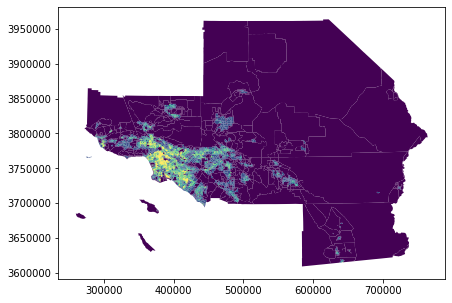

In [15]:
gdf['pop_den'] = pop_den
gdf.plot(column='pop_den', scheme='Quantiles')

One challenge with this dataset is the spatial heterogeneity in the size of the tracts. Most of the population is located towards the coast, while the massive, sparsely populated, tracts are to the east. Moreover, there is wide variation in the population density across tracts in the SCAG region:

In [16]:
pop_den.max()

45135.2488956093

In [17]:
pop_den.min()

0.0

We can focus on one county to take a closer look. Let's use Riverside County and create a smaller dataframe containing just the tracts from this county:

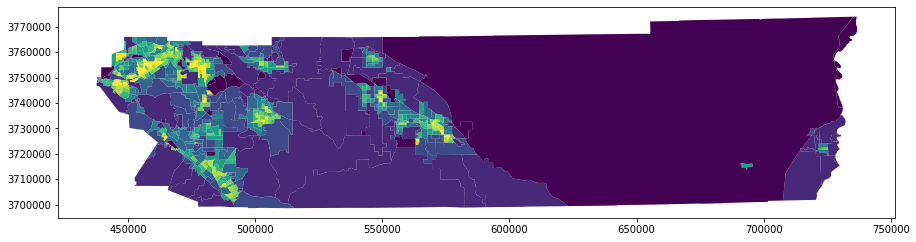

In [18]:
f, ax = plt.subplots(1, 1, figsize = (15, 15))
gdf[gdf.COUNTY=='065'].plot(column='pop_den', scheme='Quantiles', k=10, ax = ax)

We can also normalize the population counts in each tract with regard to the percentage of the overall tract population they comprise. This will be useful in the study of segregation, for example.

In [19]:
den = gdf.TOTPOP + (gdf.TOTPOP==0)

In [20]:
num_vars = ['HISP', 'NHWHT', 'NHBLK', 'NHNATIVE', 
            'NHASIAN', 'NHHWPAC', 'NHOTHER', 'NH2MORE']


In [21]:
pct_vars = [gdf[v]/den for v in num_vars]

In [22]:
pct_vars

[0       0.500000
 1       0.941276
 2       0.769007
 3       0.653181
 4       0.940945
           ...   
 5271    0.192308
 5272    0.000000
 5273    0.284314
 5274    0.159946
 5275    0.142857
 Length: 5276, dtype: float64,
 0       0.500000
 1       0.035770
 2       0.188007
 3       0.300214
 4       0.032422
           ...   
 5271    0.769231
 5272    0.000000
 5273    0.627451
 5274    0.751344
 5275    0.714286
 Length: 5276, dtype: float64,
 0       0.000000
 1       0.014083
 2       0.016215
 3       0.011437
 4       0.019222
           ...   
 5271    0.000000
 5272    0.000000
 5273    0.009804
 5274    0.012097
 5275    0.089286
 Length: 5276, dtype: float64,
 0       0.000000
 1       0.001831
 2       0.005354
 3       0.003717
 4       0.002779
           ...   
 5271    0.000000
 5272    0.000000
 5273    0.049020
 5274    0.004032
 5275    0.000000
 Length: 5276, dtype: float64,
 0       0.000000
 1       0.001267
 2       0.010402
 3       0.022159
 4       0.0

In [23]:
new_vars = [f'{name}_pct' for name in num_vars]

In [24]:
labeled = zip(new_vars, pct_vars)

In [25]:
labeled

In [26]:
for name, values in labeled:
    gdf[name] = values

In [27]:
gdf.columns

Index(['PARTIAL_ID', 'COUNTY', 'TRACT', 'CITY', 'TOTPOP', 'HISP', 'NHWHT',
       'NHBLK', 'NHNATIVE', 'NHASIAN', 'NHHWPAC', 'NHOTHER', 'NH2MORE',
       'TOTHU', 'OCCUPH', 'VACH', 'POP18', 'HISP18', 'NHWHT18', 'NHBLK18',
       'NHNATIVE18', 'NHASIAN18', 'NHHWPAC18', 'NHOTHER18', 'NH2MORE18',
       'AREA_', 'PERIMETER', 'X_CENTER', 'Y_CENTER', 'ACRES', 'Shape_area',
       'Shape_len', 'geometry', 'pop_den', 'HISP_pct', 'NHWHT_pct',
       'NHBLK_pct', 'NHNATIVE_pct', 'NHASIAN_pct', 'NHHWPAC_pct',
       'NHOTHER_pct', 'NH2MORE_pct'],
      dtype='object')

In [28]:
gdf.COUNTY.unique()

array(['025', '037', '059', '065', '071', '111'], dtype=object)

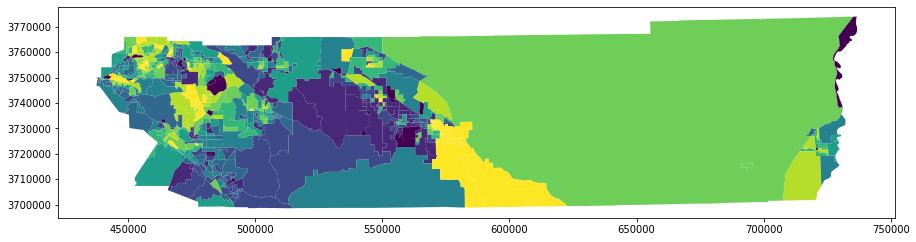

In [29]:
f, ax = plt.subplots(1, 1, figsize = (15, 15))
gdf[gdf.COUNTY=='065'].plot(column='HISP_pct', scheme='Quantiles', k=10, ax = ax)

## Saving our file
Finally, let's save our file so we can use it in other analyses:

In [30]:
gdf.to_file('scag.shp')